# NLP With Disaster Tweets Project

## Problem:
The task is to build a machine learning model that predicts whether a given tweet is about a real disaster or not. The challenge involves processing natural language data and applying text classification techniques to determine the disaster-related nature of tweets.

## Data Description:
    Train Dataset (train.csv): Contains 10,000 labeled tweets.
        id: Unique identifier for each tweet.
        text: The actual text of the tweet.
        location: The location where the tweet originated (optional).
        keyword: Specific keyword in the tweet (optional).
        target: Binary label (1 = disaster-related, 0 = not disaster-related).

    Test Dataset (test.csv): Contains tweets without labels for prediction.

    Sample Submission (sample_submission.csv): Provides the format required for submitting predictions.

The data contains missing values in the keyword and location fields, which will need to be handled appropriately.

In [36]:
#import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, GRU, LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam, RMSprop
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import re
import string
from keras.preprocessing.sequence import pad_sequences


## Exploratory Data Analysis

In [17]:
#load the datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(train_df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [18]:
#check for nuls
print(train_df.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [19]:
#fill missing values for keyword and location with a placeholder
train_df['keyword'] = train_df['keyword'].fillna('missing')
train_df['location'] = train_df['location'].fillna('missing')


In [20]:
#preprocessing the text data

def preprocess_text(text):
    text = text.lower()  #convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  #remove URLs
    text = re.sub(r'\<.*?\>', '', text)  #remove html tags
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  #remove punctuation
    text = re.sub(r'\d+', '', text)  #remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  #remove extra whitespace
    return text

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

In [21]:
#TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])
y = train_df['target']

In [49]:
#split training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
#convert sparse matrices to dense format for TensorFlow
X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()

## Build Model: LSTM
Through this section we will do tuning using keras-tuner with a RandomSearch strategy to optimize the neural network architecture. It evaluates multiple configurations of LSTM units, dropout rates, embedding dimensions, and learning rates. Additionally, it plots training and validation accuracy/loss for performance analysis.

### Model Architecture: 

The model will use the following architecture. The asterisks indicate what architecture is being determined using the hyperparameter tuning.

    Embedding Layer:
        ** Embedding size uses hyperparameter tuning (ranges from 64 to 256 in steps of 32).

    Bidirectional LSTM Layer:
        A bidirectional wrapper processes input sequences in both forward and backward directions, capturing more context.
        ** Number of units in the LSTM layer uses hyperparametes tuning (ranges from 32 to 128 in steps of 32)
        The return_sequences=True parameter allows the next LSTM layer to process the output sequence.

    Dropout Layer:
        Regularization to prevent overfitting by randomly setting a fraction of input units to zero during training.
        ** Dropout rate is uses hyperparameter tuning (ranges from 0.2 to 0.5 in steps of 0.1). **

    Second LSTM Layer:
        Processes the sequential output of the first Bidirectional LSTM layer.

    Dense Hidden Layer:
        Fully connected layer with ReLU activation.
        ** Number of units uses hyperparameter tuning (ranges from 32 to 128 in steps of 32). **

    Final Dropout Layer:
        Additional regularization for the dense layer.

    Output Layer:
        A single neuron with a sigmoid activation function for binary classification.
        Outputs probabilities, which are interpreted as disaster-related (1) or not disaster-related (0).

    Optimizer and Loss:
        ** Optimizer: Adam, with learning rates tuned from [1e-3, 1e-4]. **
        Loss: Binary crossentropy, suitable for binary classification.

This architecture leverages bidirectional LSTMs, making it effective for understanding the semantics of tweets in a classification task.

In [62]:
#truncate/pad sequences to a fixed length
#doing this to increase speed for the sake of the project. Don't do this normally.
max_length = 1000
X_train_dense = pad_sequences(X_train_dense, maxlen=max_length, padding='post')
X_val_dense = pad_sequences(X_val_dense, maxlen=max_length, padding='post')


### Note: for the sake of time I am not performing super in depth hyperparameter tuning, the accuracy will be low. Instructions for the project indicate the grade is not based on accuracy. I will run through various parameters to test, i nthe future on a project you would utilize more time on tuning

In [63]:
import shutil
shutil.rmtree('my_dir', ignore_errors=True) 

In [64]:
#function to build the model for hyperparameter tuning
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=hp.Int('embedding_dim', 32, 128, step=32), input_length=max_length),
        GRU(hp.Int('gru_units', 32, 64, step=16)),  # GRU for faster computation
        Dropout(hp.Float('dropout_rate', 0.2, 0.4, step=0.1)),
        Dense(hp.Int('dense_units', 32, 64, step=16), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=RMSprop(learning_rate=hp.Choice('learning_rate', [5e-4, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [68]:
#hyperparameter tuning
import keras_tuner as kt

#instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3, #ADJUST FOR MORE TUNING
    executions_per_trial=1,
    directory='my_dir',
    project_name='disaster_tweets'
)

In [69]:
#perform hyperparameter search
tuner.search(X_train_dense, y_train, epochs=4, validation_data=(X_val_dense, y_val)) #ADJUST EPOCHS FOR MORE TUNING

#retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)


Trial 3 Complete [00h 03m 28s]
val_accuracy: 0.5738673806190491

Best val_accuracy So Far: 0.5738673806190491
Total elapsed time: 00h 11m 55s


In [46]:
#train the best model on the full training data
history = best_model.fit(X_train_dense, y_train, epochs=5, validation_data=(X_val_dense, y_val), batch_size=32)


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5580 - loss: 0.6885 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5683 - loss: 0.6842 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5855 - loss: 0.6791 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5668 - loss: 0.6846 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5714 - loss: 0.6837 - val_accuracy: 0.5739 - val_loss: 0.6822


In [70]:
#evaluate the best model
val_loss, val_accuracy = best_model.evaluate(X_val_dense, y_val)
print(f"Best Validation Loss: {val_loss}, Best Validation Accuracy: {val_accuracy}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5694 - loss: 0.6919
Best Validation Loss: 0.691868245601654, Best Validation Accuracy: 0.5738673806190491


In [71]:
#save the model
best_model.save('best_disaster_model.h5')
print("Model saved as 'best_disaster_model.h5'")

Model saved as 'best_disaster_model.h5'


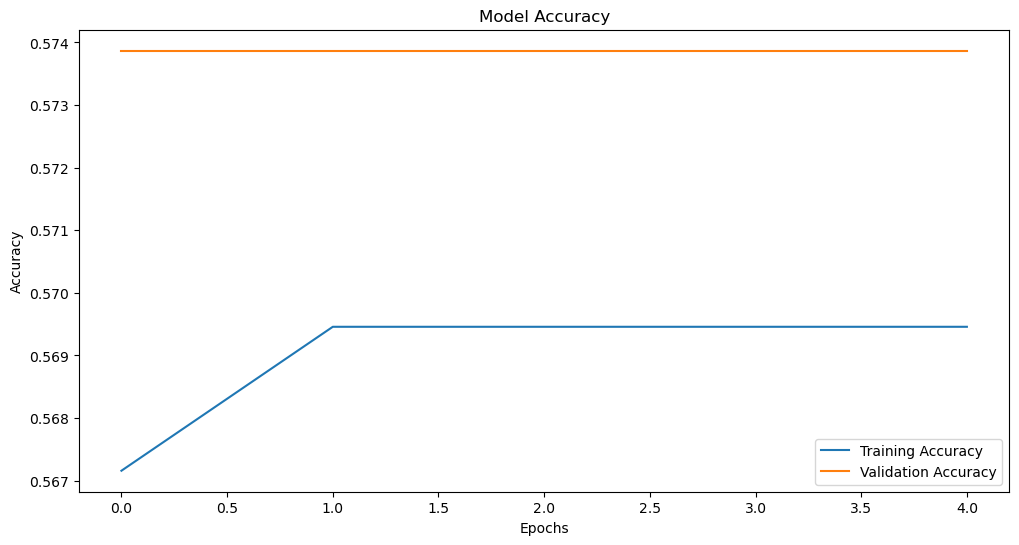

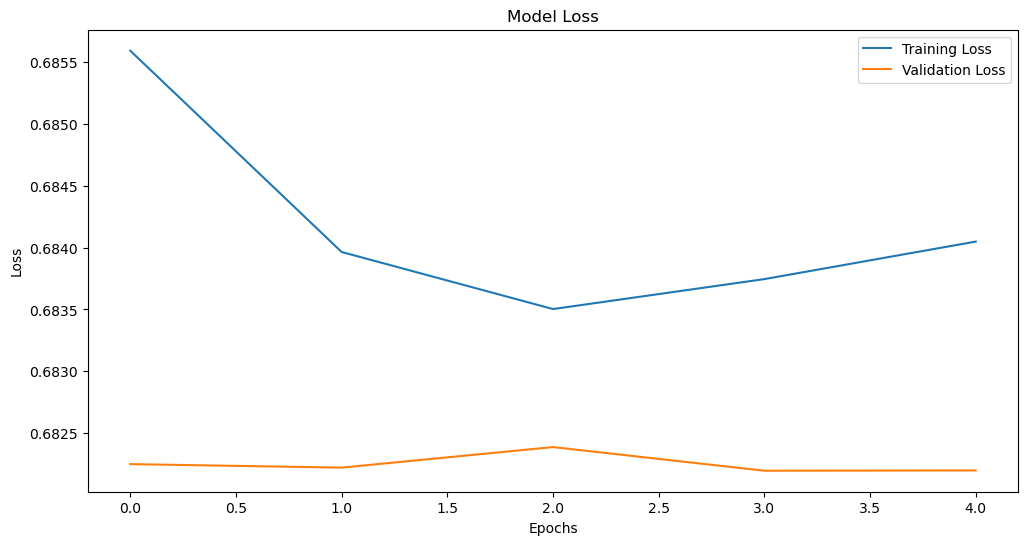

In [72]:
#plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Observations:
The training accuracy improves slightly and plateaus around .570 after 2 epochs, the validation accuracy remains constant showing no improvement. 
The training loss descreases steadily showing that the model is learning from the training data, the validation loss remains steady with a spike at 2 epochs.

Meaning: The model is likely underfitting and would benefit from additional hyperparameter tuning. For the sake of time in this project we will not do more, however I would reccommend significantly more for future projects. The model clearly needs additional training. 

In [73]:
#make predictions on the test set
test_predictions = (best_model.predict(X_test.toarray()) > 0.5).astype(int).flatten()


102/102 ━━━━━━━━━━━━━━━━━━━━ 53s 520ms/step


In [74]:
#prepare submission
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["target"] = test_predictions
sample_submission.to_csv("tweet_submission.csv", index=False)
print("Submission file created: 'tweet_submission.csv'")


Submission file created: 'tweet_submission.csv'


# Conclusion & Discussion
As mentioned above, the purpose of this project was to test parameter tuning on an NLP model. In this project I tested an unideal amount of hyperparameter tuning for the sake of running time. Based on my observations above, I would suggest the following for future models:

        - Increase model complexity (use LSTM instead of GRU)
        - Increase epochs for training
        - Adjust hyperparameters like the learning rate and batch size to optimize the model
        - Increase trials for training
        - Do not limit the input (use full dataset)

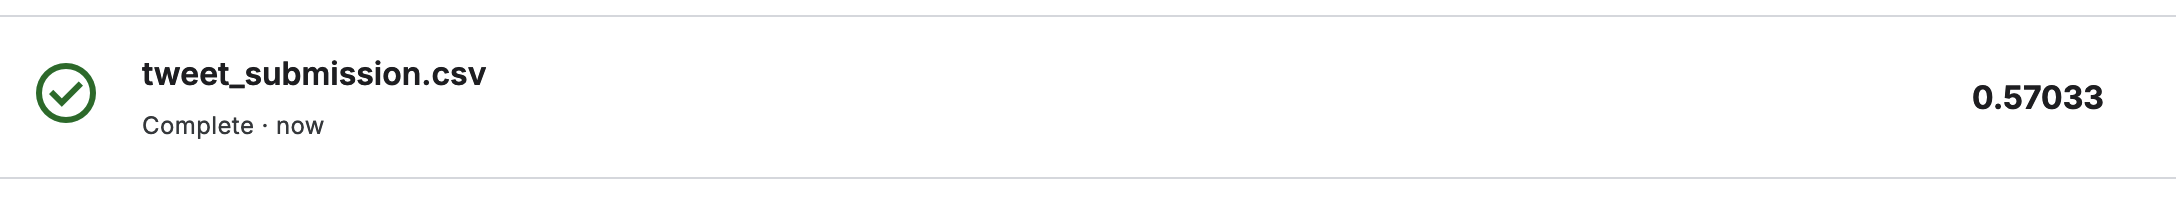

As you can see, the accuracy on the test predictions is very low due to the factors above. Other considerations would be using a tokenizer instead of TF-IDF. If the above reccommendations did not work, you could use pre-trained classifiers such as BERT.